In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import random

### Data Preparation

In [11]:
def get_dataset(directory):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                temp_label = filename.split('.')[0].split('_')[0]
                if 'a' in temp_label:
                    label ='alcoholic'
                else:
                    label = 'control'

                temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                rwb = np.load(rel_path)
                rwb.astype(np.float64).reshape(-1,1)
                # with open(rel_path, 'r') as file:
                    
                #     rwb = list(csv.reader(file, delimiter=","))[0]
                #     # scaler = preprocessing.MinMaxScaler()
                #     rwb = np.asarray(rwb).astype(np.float64).reshape(-1,1)
                #     # print(rwb)
                                
                temp_data['data'][0] = rwb
                temp_data['label'] = label
                
                # decomp = np.arange(0, 366)
                # plt.plot(decomp, df_data)
                # plt.xlabel('Dimension Number')
                # plt.ylabel('Wavelet Bispectrum Energy')
                # plt.show()
                data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"alcoholic": 1, "control": 0}
    data['label_map'] = data['label'].map(label_map)      
    return data

In [12]:
def get_batch(path):
    # loading extracted feature & label
    x = get_dataset(path)

    scaler = preprocessing.MinMaxScaler()

    series_list = [
        i for i in x["data"]
    ]

    # series_list = series_list.reshape(-1, 366, 1)

    labels_list = [i for i in x["label_map"]]
        
    # y = keras.utils.to_categorical(y[0])
    dataset = tf.data.Dataset.from_tensor_slices((series_list,labels_list))
    dataset = dataset.shuffle(len(labels_list)).batch(4)

    return dataset

In [29]:
test = get_batch('../smni_cmi_test_bispectrum_256')
for i in test:
    print(i)

(<tf.Tensor: shape=(4, 61, 202, 202), dtype=float64, numpy=
array([[[[7.02069345e+00, 1.26272822e+00, 6.01542578e+00, ...,
          1.42673452e+03, 1.52723850e+03, 5.91582323e+01],
         [1.26272822e+00, 8.56548988e-02, 1.19124614e+00, ...,
          1.15682572e+02, 6.83021804e+01, 2.99935498e-10],
         [6.01542578e+00, 1.19124614e+00, 6.56957914e+00, ...,
          3.63337153e+02, 3.44378335e-10, 6.83021804e+01],
         ...,
         [1.42673452e+03, 1.15682572e+02, 3.63337153e+02, ...,
          1.94209303e+00, 7.35765995e+00, 4.31001958e-01],
         [1.52723850e+03, 6.83021804e+01, 3.58581220e-10, ...,
          7.35765995e+00, 6.56957914e+00, 1.19124614e+00],
         [5.91582323e+01, 2.53213423e-10, 6.83021804e+01, ...,
          4.31001958e-01, 1.19124614e+00, 8.56548988e-02]],

        [[9.04211102e+00, 9.89095889e+00, 8.78760348e+00, ...,
          2.13678487e+03, 1.88278043e+03, 7.88055160e+02],
         [9.89095889e+00, 1.22668650e+01, 1.46487086e+01, ...,
       

In [13]:
del test

### Exploratory Data Analysis

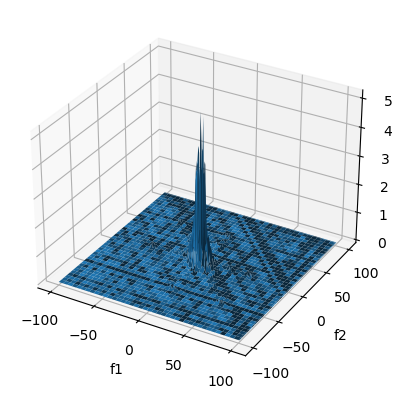

In [22]:
# Load the CSV file into a DataFrame
signal = np.load('../smni_cmi_test_bispectrum_256\co2a0000364\co2a0000364_40_bispectrum.npy')


# Plot the bispectrum using mesh plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = signal.shape[1]
X, Y = np.meshgrid([x - (n-1)//2 for x in range(n)], [x - (n-1)//2 for x in range(n)])
ax.plot_surface(X, Y, signal[4])
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Bispectrum')
plt.show()


### Model Definition

In [30]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(61, 201, 201,)))
    model.add(layers.Reshape((61, 202, 202, 1)))

    model.add(layers.Conv3D(filters=16, kernel_size=4, activation="relu"))
    model.add(layers.MaxPooling3D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(filters=8, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling3D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Define Callbacks

In [25]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensorboard_callback
    

### Main Program

In [26]:
lags = [256, 128, 64, 32, 16, 8, 4, 2]
folds = ['train_1', 'test_1', 'train_2', 'test_2']
epochs = 100
log_dir = 'logs'
train_dir = '../smni_cmi_train_bispectrum'
test_dir = '../smni_cmi_train_bispectrum'

recap = pd.DataFrame(index=lags, columns=folds)

In [31]:
for fold in range(1,3):
    for lag in [256]:
        if fold == 2:
            train_dir, test_dir = test_dir, train_dir
        
        train_temp_dir = train_dir + '_' + str(lag)
        test_temp_dir = test_dir + '_' + str(lag)

        train = get_batch('../smni_cmi_test_bispectrum_256')
        test_ds = get_batch('../smni_cmi_test_bispectrum_256')

        train_size = int(len(list(train.as_numpy_iterator()))*0.8)
        train_ds = train.take(train_size)
        val_ds = train.skip(train_size)

        log_path = os.path.join(log_dir, str(fold), str(lag))

        model = create_model()
        model.summary()

        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

        history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))
        results = model.evaluate(test_ds, callbacks = myCallbacks(log_path))

        recap.loc[lag, 'train'+ '_' + str(fold)] = history.history['acc'][-1]
        recap.loc[lag, 'test'+ '_' + str(fold)] = results[1]

        model.save(os.path.join(log_path,'model.h5'))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 61, 202, 202, 1)   0         
                                                                 
 conv3d_2 (Conv3D)           (None, 58, 199, 199, 16)  1040      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 49, 49, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 14, 49, 49, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 13, 48, 48, 8)     1032      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 12, 12, 8)    

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/max_pooling3d_2/MaxPool3D' defined at (most recent call last):
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\fulky\AppData\Local\Temp\ipykernel_12924\2988158072.py", line 23, in <module>
      history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\keras\layers\pooling\base_pooling3d.py", line 88, in call
      outputs = self.pool_function(
Node: 'sequential_1/max_pooling3d_2/MaxPool3D'
OOM when allocating tensor with shape[4,16,58,199,199] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/max_pooling3d_2/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1847]

In [18]:
recap.to_csv('../Logs/Recap/recap.csv')

In [1]:
! tensorboard --logdir logs --port=8000

^C


In [37]:
! cd

c:\Users\fulky\OneDrive - UNIVERSITAS INDONESIA\Documents\Akademik\Final Year\Seminar\Code\notebook
